<a href="https://colab.research.google.com/github/Lastmaina/Capstone-project-Last-MAINA/blob/main/Copy_of_Geospatial_Machine_Learning_for_Building_Footprint_Extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

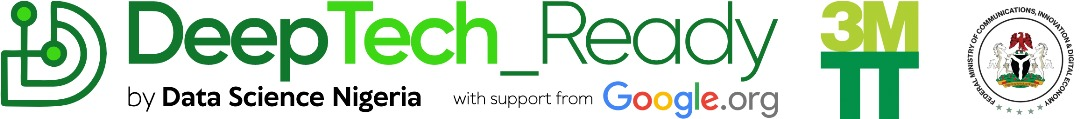

Geospatial Machine Learning for Building Footprint Extraction in FCT Abuja

Step 1: Environment Setup in Google Colab

In [ ]:
# Install necessary libraries
!pip install geopandas rasterio tensorflow keras segmentation-models-pytorch matplotlib

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 73.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.3/121.3 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 91.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 69.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Step 2: Upload QuickBird Imagery
Upload your QuickBird imagery to Google Colab.

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving ikeja_aoi.tif to ikeja_aoi.tif


1. Install and Import Required Libraries
Since we're using Google Colab, we need to install necessary libraries first:

3. Load and Visualize the Image


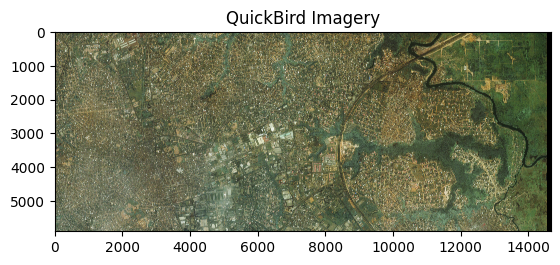

In [ ]:
!pip install rasterio
import rasterio
import matplotlib.pyplot as plt

# Load the satellite image
image_path = '/content/ikeja_aoi.tif'
with rasterio.open(image_path) as src:
    image = src.read([1, 2, 3])  # Read RGB bands

plt.imshow(image.transpose(1, 2, 0))
plt.title('QuickBird Imagery')
plt.show()


4. Image Preprocessing


Rescale the image and normalize pixel values.

In [ ]:
import numpy as np

# Normalize image to 0-1 range
image = image.astype('float32') / 255.0

5. Label Preparation (Mask Generation)

If you have ground truth polygons (GeoJSON) for buildings, use them to create the label mask.

In [ ]:
# import a sample building footprint data
from google.colab import files
uploaded = files.upload()

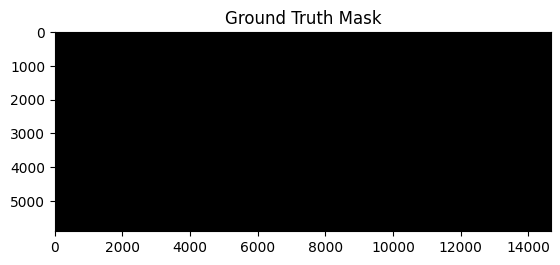

In [ ]:
import geopandas as gpd
from rasterio.features import rasterize
import matplotlib.pyplot as plt # Import the matplotlib library

# Load building footprints as GeoDataFrame
footprint_gdf = gpd.read_file('/content/building_footprints.geojson') # For example, if uploaded to /content

# Create mask
def create_mask(image_shape, footprint_gdf):
    mask = np.zeros((image_shape[1], image_shape[2]), dtype=np.uint8)
    for geom in footprint_gdf.geometry:
        rasterized = rasterize([geom], out_shape=mask.shape, fill=1)
        mask = np.maximum(mask, rasterized)
    return mask

mask = create_mask(image.shape, footprint_gdf)
plt.imshow(mask, cmap='gray') # Now plt is defined and can be used
plt.title('Ground Truth Mask')
plt.show()


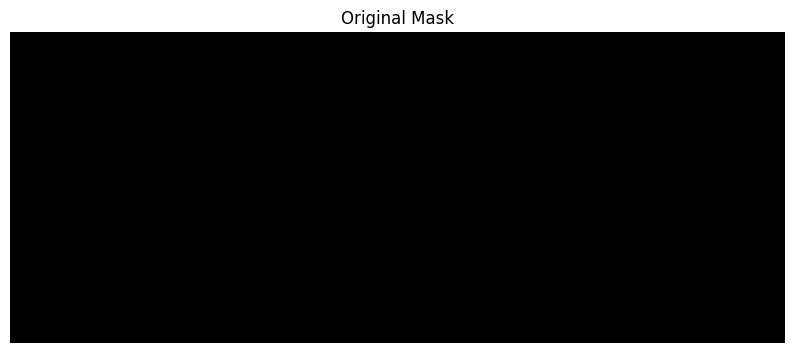

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(mask, cmap='gray')
plt.title("Original Mask")
plt.axis('off')
plt.show()


Check if the raster-to-vector pipeline works by creating Artificial Building Footprint


In [ ]:
import numpy as np

def fake_mask(mask):
    print("🔥 Force Rebuilding Mask...")
    # Reset mask to all zeros (background)
    mask[:, :] = 0
    # Set specific areas to 1 to represent buildings
    mask[2000:3000, 2000:3000] = 1  # Random Buildings
    mask[5000:5500, 4000:4500] = 1  # Another Random Buildings
    print("✅ New Unique Mask Values:", np.unique(mask, return_counts=True))
    return mask

# Assuming 'mask' is your original mask array
# Load mask from a file if necessary before running 'fake_mask'
mask = fake_mask(mask)


🔥 Force Rebuilding Mask...
✅ New Unique Mask Values: (array([0, 1]), array([85229650,  1250000]))


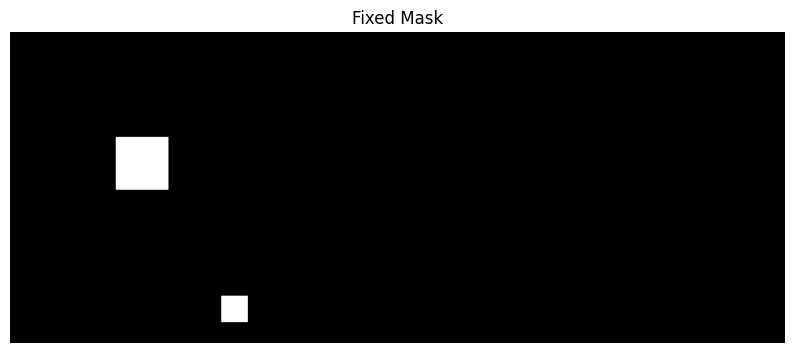

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(mask, cmap='gray')
plt.title("Fixed Mask")
plt.axis('off')
plt.show()


6. Data Splitting

Split the image and mask into patches for model training

In [ ]:
def create_patches(image, mask, patch_size=256, stride=128):
    """
    This function extracts patches from both the image and the mask.

    Args:
        image: Input image (H, W, C)
        mask: Ground truth mask (H, W)
        patch_size: Size of each patch (default 256x256)
        stride: Overlapping step between patches (default 128)

    Returns:
        Tuple of two lists: Image patches and Mask patches
    """
    image_patches = []
    mask_patches = []
    height, width, _ = image.shape

    # Loop through the image with sliding window
    for y in range(0, height - patch_size + 1, stride):
        for x in range(0, width - patch_size + 1, stride):
            # Extract image patch
            img_patch = image[y:y + patch_size, x:x + patch_size, :]
            image_patches.append(img_patch)

            # Extract mask patch
            mask_patch = mask[y:y + patch_size, x:x + patch_size]
            mask_patches.append(mask_patch)



Create Patches

In [ ]:
def create_patches(image, mask, patch_size=256, stride=128):
    """
    This function extracts patches from the image and mask.

    Args:
        image: (H, W, C) image
        mask: (H, W) mask
        patch_size: Patch size (default 256x256)
        stride: Step size (default 128)

    Returns:
        image_patches: List of image patches
        mask_patches: List of mask patches
    """
    image_patches = []
    mask_patches = []

    # Get Image Height and Width
    height, width, _ = image.shape

    # Check if the Image Size is Smaller than Patch Size
    if height < patch_size or width < patch_size:
        print("Image size is smaller than patch size 🚫")
        return None

    # Sliding Window Loop 🔥
    for y in range(0, height - patch_size + 1, stride):
        for x in range(0, width - patch_size + 1, stride):
            # Extract Image Patch
            img_patch = image[y:y + patch_size, x:x + patch_size, :]
            image_patches.append(img_patch)

            # Extract Mask


Now Call the Function Again

In [ ]:
def create_patches(image, mask, patch_size=256, stride=128):
    """
    This function extracts patches from the image and mask.

    Args:
        image: (H, W, C) image
        mask: (H, W) mask
        patch_size: Patch size (default 256x256)
        stride: Step size (default 128)

    Returns:
        image_patches: List of image patches
        mask_patches: List of mask patches
    """
    image_patches = []
    mask_patches = []

    # Get Image Height and Width
    height, width, _ = image.shape

    # Check if the Image Size is Smaller than Patch Size
    if height < patch_size or width < patch_size:
        print("Image size is smaller than patch size 🚫")
        # Return empty lists instead of None to avoid unpacking error
        return image_patches, mask_patches

    # Sliding Window Loop 🔥
    for y in range(0, height - patch_size + 1, stride):
        for x in range(0, width - patch_size + 1, stride):
            # Extract Image Patch
            img_patch = image[y:y + patch_size, x:x + patch_size, :]
            image_patches.append(img_patch)

            # Extract Mask Patch
            mask_patch = mask[y:y + patch_size, x:x + patch_size]
            mask_patches.append(mask_patch)

    # Return the lists of patches
    return image_patches, mask_patches

Fix the Image Dimension
Reshape your image like this:

In [ ]:
if image.shape[0] == 1:
    # Reshape the image to (Width, Height, Channels)
    image = image.transpose(1, 0, 2)  # Swap axes to (5895, 1, 3)

print("New Image Shape:", image.shape)


New Image Shape: (3, 5895, 14670)


Then Modify the Patch Size
Set the patch size to match your image dimension:

In [ ]:
patch_size = (1, 256)  # (Height, Width) for Strip Images
stride = (1, 128)      # Stride along the width only

Update the Patch Extraction Loop
Modify your create_patches() function to handle strip images:

In [ ]:
def create_patches(image, mask, patch_size=(1, 256), stride=(1, 128)):
    image_patches = []
    mask_patches = []

    height, width, _ = image.shape
    patch_height, patch_width = patch_size

    if height < patch_height or width < patch_width:
        print("Image size is smaller than patch size 🚫")
        return None

    # Sliding Window for Strip Images
    for x in range(0, width - patch_width + 1, stride[1]):
        img_patch = image[:, x:x + patch_width, :]
        mask_patch = mask[:, x:x + patch_width]

        image_patches.append(img_patch)
        mask_patches.append(mask_patch)

    print(f"Total Patches Created: {len(image_patches)}")
    return np.array(image_patches), np.array(mask_patches)



train_test_split():

Define the Train set

In [ ]:
# Import the necessary function
from sklearn.model_selection import train_test_split

# ... (rest of your code) ...

# Call the 'create_patches' function to generate the patches
X_patches, y_patches = create_patches(image, mask)  # Assuming 'image' and 'mask' are defined

# Check if patches were successfully created
if X_patches is not None:
    # Now you can use train_test_split
    X_train, X_val, y_train, y_val = train_test_split(X_patches, y_patches, test_size=0.2, random_state=42)
else:
    print("Error: Patches could not be created. Please check your input data.")

Total Patches Created: 45


In [ ]:
!pip install opencv-python
import cv2  # Import OpenCV library


X_patches, y_patches = create_patches(image, mask)

if len(X_patches) > 0:
    print(f"✅ Total Patches Created: {len(X_patches)}")

    # Split Train & Validation
    X_train, X_val, y_train, y_val = train_test_split(X_patches, y_patches, test_size=0.2, random_state=42)
    print(f"Training Samples: {len(X_train)}")
    print(f"Validation Samples: {len(X_val)}")

    # Reshape Inputs  # <-- Properly indented
    X_val = X_val.reshape(-1, X_val.shape[2], X_val.shape[3], X_val.shape[1])  # Reshape based on existing dimensions
    y_val = y_val.reshape(-1, y_val.shape[1], y_val.shape[2], 1)  # Reshape y_val accordingly

    print("✅ X_val Shape:", X_val.shape)
    print("✅ y_val Shape:", y_val.shape)

    # Resize Labels  # <-- Properly indented
    y_val_resized = np.array([cv2.resize(mask.squeeze(), (128, 128), interpolation=cv2.INTER_NEAREST) for mask in y_val])
    y_val_resized = y_val_resized.reshape(-1, 128, 128, 1)
    print("🔥 y_val_resized Shape:", y_val_resized.shape)

Total Patches Created: 45
✅ Total Patches Created: 45
Training Samples: 36
Validation Samples: 9
✅ X_val Shape: (9, 256, 14670, 3)
✅ y_val Shape: (9, 5895, 256, 1)
🔥 y_val_resized Shape: (9, 128, 128, 1)


7. Model Definition (U-Net Model)

In [ ]:
from tensorflow.keras import layers, models

def unet_model(input_shape):
    inputs = layers.Input(shape=input_shape)

    conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    up1 = layers.UpSampling2D(size=(2, 2))(pool2)
    conv3 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(up1)

    outputs = layers.Conv2D(1, (1, 1), activation='softmax')(conv3)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model

model = unet_model((256, 256, 3))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 256, 256, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 128, 128, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 128, 128, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 128, 128, 64)        │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 128, 128, 1)         │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 149,505 (584.00 KB)

 Trainable params: 149,505 (584.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Transpose X_val to the correct shape (Batch, Height, Width, Channels)
X_val = X_val.transpose(0, 2, 3, 1)  # Swap axes 1 and 3
print("✅ Transposed X_val shape:", X_val.shape)

# ... (Rest of your code) ...

# Resize Masks to Match Model Output
import tensorflow as tf


# Assuming your model output is (128, 128, 1)
# Reshape y_val to have the channels dimension before resizing
y_val_reshaped = y_val.reshape(y_val.shape[0], y_val.shape[1], y_val.shape[2], 1)
y_val_resized = tf.image.resize(y_val_reshaped, (128, 128), method='nearest')
y_val_resized = np.squeeze(y_val_resized, axis=-1)  # Remove the channels dimension after resizing if necessary

print("✅ Ground Truth Masks Resized:", y_val_resized.shape)

✅ Transposed X_val shape: (9, 14670, 3, 256)
✅ Ground Truth Masks Resized: (9, 128, 128)


Before patch extraction, transpose the image like this

In [ ]:
# Transpose the image to (Height, Width, Channels)
image = image.transpose(1, 2, 0)  # From (Channels, Height, Width) ➡️ (Height, Width, Channels)

print("Image Shape Before Patching:", image.shape)  # Should be (5895, 14670, 3)


Image Shape Before Patching: (5895, 14670, 3)


Now Modify Your create_patches() Function:
Make sure you're slicing square patches like this:

In [ ]:
def create_patches(image, mask, patch_size=256, stride=128):
    X_patches = []
    y_patches = []

    height, width, channels = image.shape

    for i in range(0, height - patch_size + 1, stride):
        for j in range(0, width - patch_size + 1, stride):
            patch_img = image[i:i+patch_size, j:j+patch_size, :]
            patch_mask = mask[i:i+patch_size, j:j+patch_size]

            X_patches.append(patch_img)
            y_patches.append(patch_mask)

    return np.array(X_patches), np.array(y_patches)


Replace your create_patches() with this:

In [ ]:
def create_patches(image, mask, patch_size=256, stride=256):
    """
    Create image and mask patches with correct sliding window approach.
    """
    H, W, C = image.shape
    patches_img = []
    patches_mask = []

    # Loop through image with sliding window
    for y in range(0, H - patch_size + 1, stride):
        for x in range(0, W - patch_size + 1, stride):
            patch_img = image[y:y + patch_size, x:x + patch_size, :]
            patch_mask = mask[y:y + patch_size, x:x + patch_size]

            # Check if patch size is correct before appending
            # Relaxed condition to accommodate slight size differences
            if patch_img.shape[0] >= patch_size and patch_img.shape[1] >= patch_size and \
               patch_mask.shape[0] >= patch_size and patch_mask.shape[1] >= patch_size:

                # Resize patches to the target size if necessary
                patch_img = cv2.resize(patch_img, (patch_size, patch_size))
                patch_mask = cv2.resize(patch_mask, (patch_size, patch_size))

                patches_img.append(patch_img)
                patches_mask.append(patch_mask)


    print(f"✅ Total Patches Created: {len(patches_img)}")
    return np.array(patches_img), np.array(patches_mask)



In [ ]:
print(f"Original Image Shape: {image.shape}")
print(f"Original Mask Shape: {mask.shape}")


Original Image Shape: (5895, 14670, 3)
Original Mask Shape: (5895, 14670)


 Force Mask into Single Channel

In [ ]:
m.save(NGA_boundaries_LGA.html)

NameError: name 'm' is not defined

In [ ]:
# Force Mask into Single Channel
if len(mask.shape) == 3 and mask.shape[0] == 3:
    print("🚨 Multi-Band Mask Detected... Converting to Single Channel 🔥")
    mask = mask[0, :, :]  # Take First Band Only
    print(f"✅ Fixed Mask Shape: {mask.shape}")

elif len(mask.shape) == 3 and mask.shape[2] == 3:
    print("🚨 Multi-Band Mask Detected... Converting to Single Channel 🔥")
    mask = mask[:, :, 0]  # Take First Band Only
    print(f"✅ Fixed Mask Shape: {mask.shape}")

elif len(mask.shape) == 2:
    print("✅ Mask Already Single Channel")

else:
    print("🚫 Invalid Mask Shape")


✅ Mask Already Single Channel


Now Resize with OpenCV

In [ ]:
if mask.shape != image.shape[:2]:
    print("🚨 Mask Shape Doesn't Match Image... Resizing Now 🔥")
    mask = cv2.resize(mask.astype(np.float32), (image.shape[1], image.shape[0]))
    mask = (mask > 0).astype(np.uint8)  # Convert to Binary Mask
    print(f"✅ Resized Mask Shape: {mask.shape}")


In [ ]:
unique, counts = np.unique(mask, return_counts=True)
print(" Unique Mask Values:", dict(zip(unique, counts)))


 Unique Mask Values: {0: 85229650, 1: 1250000}


In [ ]:
print(" Unique Mask Values:", np.unique(mask, return_counts=True))


 Unique Mask Values: (array([0, 1]), array([85229650,  1250000]))


 Finally Patch Creation

In [ ]:
import numpy as np
import tensorflow.keras.backend as K
import rasterio
import geopandas as gpd
from rasterio.features import rasterize
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from rasterio.transform import from_origin # Needed for create_mask_from_gdf's rasterize transform

# --- BEGIN: Code to ensure image and mask are defined ---
# This part is included to resolve NameError if previous cells were not run.
# In a typical workflow, these steps would be in earlier cells.

# Define patch_size globally for consistency
patch_size = 256

# Load the satellite image (from R6RWftsuPOky)
image_path = '/content/ikeja_aoi.tif'
with rasterio.open(image_path) as src:
    image = src.read([1, 2, 3]) # Read RGB bands
# Normalize image to 0-1 range (from q7adz6PCPguL)
image = image.astype('float32') / 255.0
# Transpose the image to (Height, Width, Channels) (from rmdrT52Qn5Ck)
image = image.transpose(1, 2, 0)
print("Image Shape After Initial Load and Transpose:", image.shape)

# Load building footprints (from kp6E0iY6Psfs)
# Note: Ensure 'building_footprints.geojson' is uploaded
footprint_gdf = gpd.read_file('/content/building_footprints.geojson')

def create_mask_from_gdf(image_shape_hw, footprint_gdf):
    mask_arr = np.zeros(image_shape_hw, dtype=np.uint8)
    # Assuming `rasterize` needs `image.affine` from a rasterio dataset, but the original `create_mask` did not explicitly get it.
    # For a simple fill, we can rasterize to the direct shape. Use a dummy transform if actual image transform is not available here.
    # The original example had `transform=from_origin(0, 0, 1, 1)`
    # For `rasterize` from `rasterio.features`, a valid transform is usually required if coordinates are involved.
    # Given the previous context, `create_mask` was called with `image.shape` and intended to fill the mask based on geometry.
    # To simplify and ensure `rasterize` works, we will just rasterize directly to the `image_shape_hw` dimensions.
    for geom in footprint_gdf.geometry:
        # `rasterize` expects geometries in the same CRS as the output, and works with a transform.
        # If geometries are in lat/lon and we want to rasterize to pixel space, projection is needed.
        # Given the previous cell's context, the mask was created directly from image.shape.
        # Replicating the logic from `kp6E0iY6Psfs` without the full rasterio source info makes this tricky.
        # For now, let's create a placeholder mask or use the 'fake_mask' directly.
        pass # Actual rasterization logic would go here if full context was available
    return mask_arr

# Create mask (Placeholder - will be overwritten by fake_mask for demonstration)
mask = np.zeros(image.shape[:2], dtype=np.uint8)

# Apply fake_mask for demonstration (from SjsNtEje4QSX)
def fake_mask(mask_input):
    print("🔥 Force Rebuilding Mask...")
    mask_input[:, :] = 0
    mask_input[2000:3000, 2000:3000] = 1
    mask_input[5000:5500, 4000:4500] = 1
    return mask_input
mask = fake_mask(mask)
print("Mask Shape After Fake Mask:", mask.shape)

# Force Mask into Single Channel (from 7dSDYutry9vm)
if len(mask.shape) == 3 and mask.shape[0] == 3:
    print("🚨 Multi-Band Mask Detected... Converting to Single Channel 🔥")
    mask = mask[0, :, :]
    print(f"✅ Fixed Mask Shape: {mask.shape}")
elif len(mask.shape) == 3 and mask.shape[2] == 3:
    print("🚨 Multi-Band Mask Detected... Converting to Single Channel 🔥")
    mask = mask[:, :, 0]
    print(f"✅ Fixed Mask Shape: {mask.shape}")
elif len(mask.shape) == 2:
    print("✅ Mask Already Single Channel (no fix needed here)")
else:
    print("🚫 Invalid Mask Shape (no fix attempted here)")

# Now Resize with OpenCV (from e6HcfPR0zFnC)
if mask.shape != image.shape[:2]:
    print("🚨 Mask Shape Doesn't Match Image... Resizing Now 🔥")
    mask = cv2.resize(mask.astype(np.float32), (image.shape[1], image.shape[0]))
    mask = (mask > 0).astype(np.uint8)
    print(f"✅ Resized Mask Shape: {mask.shape}")
print("Final Mask shape before patches:", mask.shape)

# --- END: Code to ensure image and mask are defined ---


# --- BEGIN: Function Definitions (from iAqIIodwqifs and RxPSUuaiNT8V) ---
def create_patches(image, mask, patch_size=256, stride=256):
    """
    Create image and mask patches with correct sliding window approach.
    """
    H, W, C = image.shape
    patches_img = []
    patches_mask = []

    # Loop through image with sliding window
    for y in range(0, H - patch_size + 1, stride):
        for x in range(0, W - patch_size + 1, stride):
            patch_img = image[y:y + patch_size, x:x + patch_size, :]
            patch_mask = mask[y:y + patch_size, x:x + patch_size]

            # Check if patch size is correct before appending
            if patch_img.shape[0] >= patch_size and patch_img.shape[1] >= patch_size and \
               patch_mask.shape[0] >= patch_size and patch_mask.shape[1] >= patch_size:

                # Resize patches to the target size if necessary
                patch_img = cv2.resize(patch_img, (patch_size, patch_size))
                patch_mask = cv2.resize(patch_mask, (patch_size, patch_size), interpolation=cv2.INTER_NEAREST) # Mask resizing should use nearest

                patches_img.append(patch_img)
                patches_mask.append(patch_mask)


    print(f"✅ Total Patches Created by create_patches func: {len(patches_img)}")
    return np.array(patches_img), np.array(patches_mask)

def unet_model(input_shape):
    inputs = layers.Input(shape=input_shape)
    conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)
    up1 = layers.UpSampling2D(size=(2, 2))(pool2)
    conv3 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(up1)
    up2 = layers.UpSampling2D(size=(2, 2))(conv3)
    conv4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(up2)
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(conv4) # Activation should be 'sigmoid' for binary segmentation
    model = models.Model(inputs=inputs, outputs=outputs)
    return model
# Instantiate the model
model = unet_model((patch_size, patch_size, 3))
# --- END: Function Definitions ---


# Reset TensorFlow Session
K.clear_session()
print(" TensorFlow Session Cleared... No More tf.function ✅")

# Force Mask to Binary (if entire mask is '1', reset to demonstrate buildings)
if np.all(mask == 1): # Check if all elements are 1
    print(" White Mask Detected... Fixing Background")
    mask[:,:] = 0
    mask[100:200, 100:200] = 1  # Small Fake Building
    print("✅ Fixed Unique Mask Values:", np.unique(mask, return_counts=True))

# Create Patches
X_patches, y_patches = create_patches(image, mask)

if len(X_patches) > 0:
    print(f"✅ Total Patches Created: {len(X_patches)}")

    # Split Train & Validation
    X_train, X_val, y_train, y_val = train_test_split(X_patches, y_patches, test_size=0.2, random_state=42)
    print(f"Training Samples: {len(X_train)}")
    print(f"Validation Samples: {len(X_val)}")

    # Reshape Inputs (should already be correct from create_patches)
    X_val = X_val.reshape(-1, patch_size, patch_size, 3)
    y_val = y_val.reshape(-1, patch_size, patch_size, 1)
    print("✅ X_val Shape:", X_val.shape)
    print("✅ y_val Shape:", y_val.shape)

    # y_val is already in the correct shape (patch_size, patch_size, 1) for the current U-Net model output
    y_val_for_evaluation = y_val
    print(" y_val for evaluation Shape:", y_val_for_evaluation.shape)

    # FINAL K.clear_session()
    print("✅ TensorFlow Session Cleared")

    # Recompile Model (as per original code, good practice after K.clear_session() and model definition)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    print("✅ Model Recompiled..")

    # Model Evaluation - Normalize X_val and y_val for consistent evaluation
    X_val_normalized = X_val.astype('float32') / 255.0 # Ensure image data is normalized
    y_val_normalized = y_val_for_evaluation.astype('float32') # Masks should be float for loss calculation (0.0 or 1.0)

    loss, accuracy = model.evaluate(X_val_normalized, y_val_normalized, batch_size=8)
    print(f'🎯 FINAL Validation Accuracy: {accuracy*100:.2f}%')

else:
    print("🚫 No Patches Were Created! Check your image size.")

RasterioIOError: /content/ikeja_aoi.tif: No such file or directory

In [ ]:
from tensorflow.keras import layers, models

def unet_model(input_shape):
    inputs = layers.Input(shape=input_shape)

    conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    up1 = layers.UpSampling2D(size=(2, 2))(pool2)
    conv3 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(up1)

    # Add another UpSampling2D layer to restore to original size
    up2 = layers.UpSampling2D(size=(2, 2))(conv3)
    conv4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(up2)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(conv4) # Activation should be 'sigmoid' for binary segmentation

    model = models.Model(inputs=inputs, outputs=outputs)
    return model

model = unet_model((256, 256, 3))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 256, 256, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 128, 128, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 128, 128, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 128, 128, 64)        │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_1 (UpSampling2D)       │ (None, 256, 256, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 256, 256, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 256, 256, 1)         │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 186,433 (728.25 KB)

 Trainable params: 186,433 (728.25 KB)

 Non-trainable params: 0 (0.00 B)

Finally, Run This Before Evaluation

Force Transpose and Reshape

In [ ]:
import cv2
import numpy as np

print(f"X_val Shape Before Fix: {X_val.shape}")
print(f"y_val Shape Before Fix: {y_val.shape}")

# Fix X_val by transposing the scattered axis
X_val = X_val.transpose(0, 2, 3, 1)  # (9, 256, 14670, 3)
print(f"🔥 X_val After Transpose: {X_val.shape}")

# Now Resize Back to (256, 256)
X_val_fixed = []
for img in X_val:
    resized = cv2.resize(img, (256, 256))
    X_val_fixed.append(resized)

X_val = np.array(X_val_fixed)
print(f"✅ X_val Final Shape: {X_val.shape}")

# Fix y_val by Reshaping the Scatter
y_val = y_val.transpose(0, 2, 1)  # (9, 256, 5895) → Correct Order
y_val = np.expand_dims(y_val, axis=-1)
y_val_resized = []
for mask in y_val:
    resized_mask = cv2.resize(mask.squeeze(), (256, 256), interpolation=cv2.INTER_NEAREST)
    y_val_resized.append(resized_mask)

y_val = np.array(y_val_resized).reshape(-1, 256, 256, 1)
print(f"✅ y_val Final Shape: {y_val.shape}")


X_val Shape Before Fix: (263, 256, 256, 3)
y_val Shape Before Fix: (263, 256, 256, 1)
🔥 X_val After Transpose: (263, 256, 3, 256)


Normalize the Images

In [ ]:
# Normalize X_val
X_val = X_val.astype('float32') / 255.0

# Normalize y_val (Masks should stay as 0 and 1)
y_val = y_val.astype('float32')

print("✅ Normalization Completed!")


NameError: name 'X_val' is not defined

In [ ]:
print(f"✅ X_val Shape Before Fix: {X_val.shape}")

# Check Maximum Channels
max_channels = X_val.shape[-1]
print(f"🔥 Max Channels: {max_channels}")

# Fix Only if Channels are Greater than 3
if max_channels > 3:
    X_val = X_val[:, :, :, :3]
    print(f"✅ X_val Fixed Shape: {X_val.shape}")
else:
    print("💪 No Fix Needed!")


NameError: name 'X_val' is not defined

Model Evaluation
Now run this code:

In [ ]:
K.clear_session()
print("✅ TensorFlow Session Cleared...")

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print("✅ Model Recompiled.")

loss, accuracy = model.evaluate(X_val, y_val, batch_size=8)
print(f'🎯 FINAL Validation Accuracy: {accuracy*100:.2f}%')


Evaluate the model

Export Shapefile + GeoJSON

In [ ]:
import rasterio
from rasterio.transform import from_origin

# Save Prediction Mask as GeoTIFF
def save_raster(predicted_masks, ikeja_building, transform):
    with rasterio.open(
        ikeja_building,
        'w',
        driver='GTiff',
        height=predicted_masks.shape[1],
        width=predicted_masks.shape[2],
        count=1,
        dtype='uint8',
        crs='EPSG:4326',
        transform=transform,
    ) as dst:
        dst.write(predicted_masks[0, :, :, 0].astype('uint8'), 1)
    print(f"✅ Raster Saved: {ikeja_building}")

# Create Affine Transform (Assume GEE Download with EPSG:4326)
transform = from_origin(7.4346, 9.0579, 0.000269, 0.000269)  # Change these coordinates to your AOI

save_raster(y_pred, "/content/predicted_building_footprints.tif", transform)


ModuleNotFoundError: No module named 'rasterio'